<a href="https://colab.research.google.com/github/jella/playstore-sentiment-analysis/blob/main/notebook/notebook_sentimentos_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Análise de Sentimentos - Google Play Store Reviews

Este projeto tem como objetivo construir um modelo de Machine Learning para classificar avaliações de usuários como **positivas** ou **negativas** com base no conteúdo textual das reviews na Google Play Store.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, joblib

import nltk

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


### Carga dos Dados

In [ ]:

url = 'https://raw.githubusercontent.com/jella/playstore-sentiment-analysis/refs/heads/main/dataset/reviews.csv'
df = pd.read_csv(url)
df[['content', 'score']].head()


KeyError: ('content', 'score')

### Análise Exploratória

<class 'pandas.core.frame.DataFrame'>
Index: 10504 entries, 0 to 12494
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10504 non-null  object
 1   userName              10504 non-null  object
 2   userImage             10504 non-null  object
 3   content               10504 non-null  object
 4   score                 10504 non-null  int64 
 5   thumbsUpCount         10504 non-null  int64 
 6   reviewCreatedVersion  8678 non-null   object
 7   at                    10504 non-null  object
 8   replyContent          4657 non-null   object
 9   repliedAt             4657 non-null   object
 10  sortOrder             10504 non-null  object
 11  appId                 10504 non-null  object
 12  sentiment             10504 non-null  int64 
 13  clean_content         10504 non-null  object
dtypes: int64(3), object(11)
memory usage: 1.2+ MB


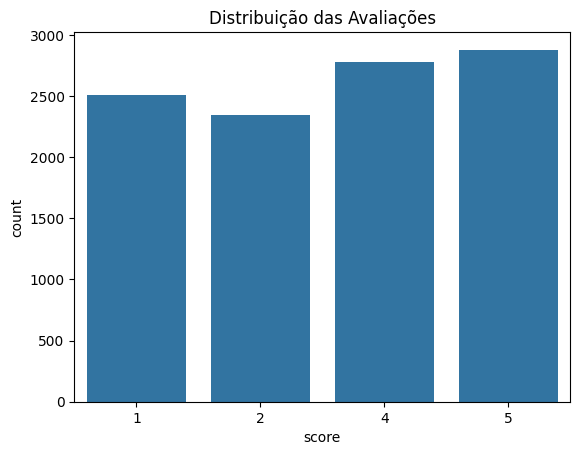

KeyError: ('content', 'score')

In [ ]:

df.info()
df.isnull().sum()
sns.countplot(x='score', data=df)
plt.title('Distribuição das Avaliações')
plt.show()



### Pré-processamento e Limpeza

In [ ]:

df.dropna(subset=['content', 'score'], inplace=True)
df = df[df['score'] != 3]
df['sentiment'] = df['score'].apply(lambda x: 1 if x >= 4 else 0)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

stop_words = set(stopwords.words('english'))
df['clean_content'] = df['content'].apply(clean_text)
df['clean_content'] = df['clean_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


### Separação Treino/Teste (Holdout)

In [ ]:

SEED = 42
X = df['clean_content']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)


### Transformação de Dados (Normalização e Padronização)

Neste projeto, os dados de entrada são textos, que foram transformados em vetores numéricos utilizando o **TF-IDF (Term Frequency–Inverse Document Frequency)**. O `TfidfVectorizer`:

- Já realiza uma **normalização interna dos vetores** (L2, por padrão).
- Gera uma **matriz esparsa**, onde aplicar `StandardScaler` ou `MinMaxScaler` **não faz sentido nem é necessário**.
- É apropriado para alimentar modelos diretamente, como Naive Bayes, SVM linear, KNN e Decision Tree, sem escalonamento adicional.

#### Conclusão:

Não aplicamos técnicas adicionais de normalização ou padronização neste pipeline, pois:
- O vetor TF-IDF já está em escala relativa e normalizada.
- Os modelos utilizados funcionam corretamente com os dados da forma atual.
- A aplicação de scalers em vetores de texto pode até prejudicar o desempenho ou gerar erros.

### Modelagem com Algoritmos Clássicos (Linha de Base)


📌 Modelo (linha base): Naive Bayes
Accuracy: 0.8496
Precision: 0.8515
Recall: 0.8731
F1: 0.8620

📌 Modelo (linha base): SVM
Accuracy: 0.8404
Precision: 0.8508
Recall: 0.8539
F1: 0.8520

📌 Modelo (linha base): KNN
Accuracy: 0.5823
Precision: 0.5707
Recall: 0.9091
F1: 0.7005

📌 Modelo (linha base): Decision Tree
Accuracy: 0.7600
Precision: 0.7591
Recall: 0.8118
F1: 0.7845


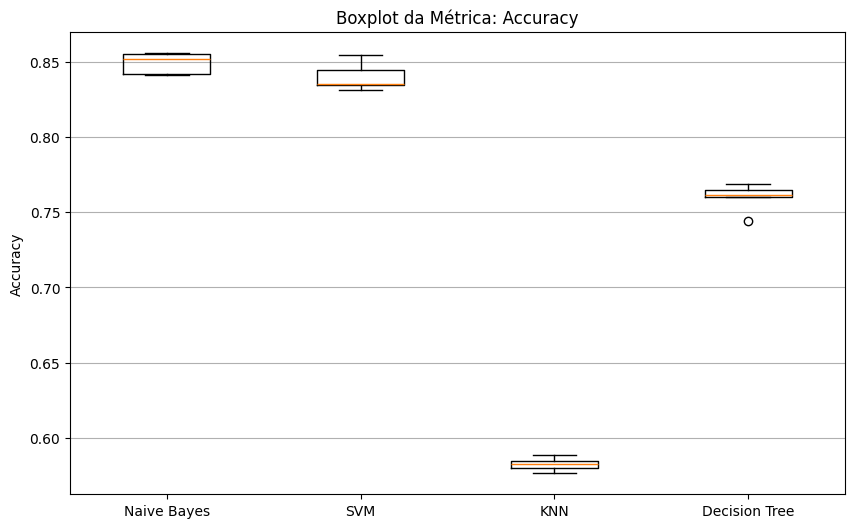

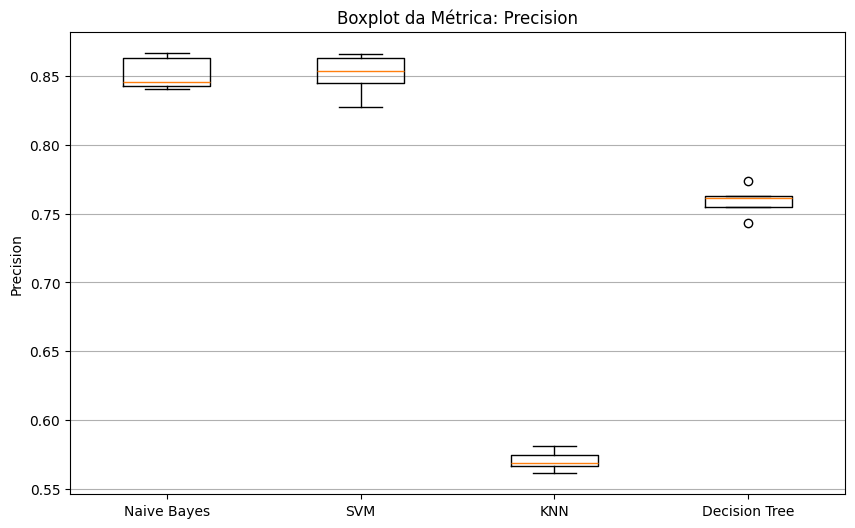

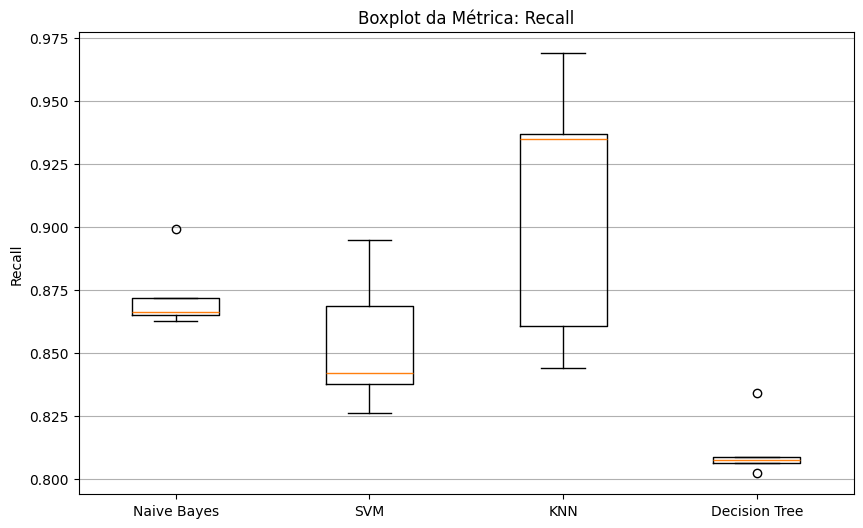

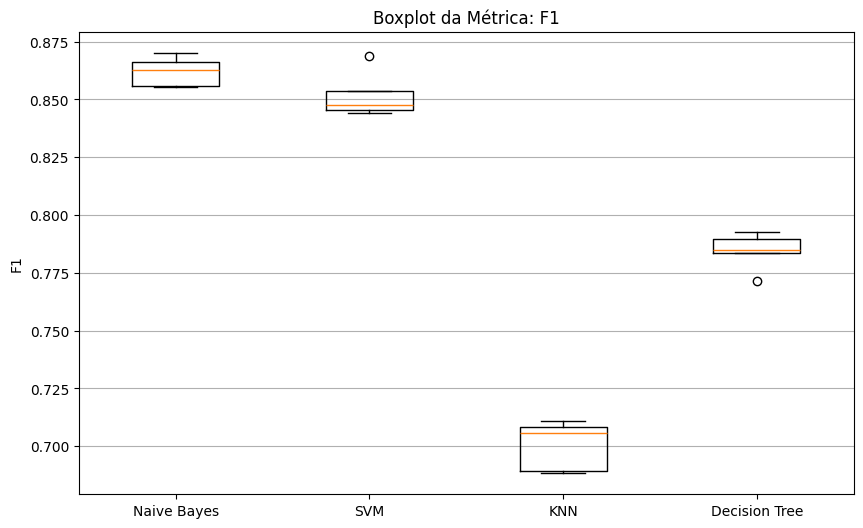

In [ ]:
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd

baseline_models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Armazenar resultados
metricas = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}
nomes_modelos = []

for nome, modelo in baseline_models.items():
    print(f"\n📌 Modelo (linha base): {nome}")
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', modelo)
    ])

    scores = cross_validate(
        pipe, X_train, y_train,
        cv=5,
        scoring=['accuracy', 'precision', 'recall', 'f1'],
        return_train_score=False
    )

    # Guardar métricas por modelo
    for metrica in metricas:
        metricas[metrica].append(scores[f'test_{metrica}'])

    nomes_modelos.append(nome)

    # Exibir médias
    for metrica in metricas:
        print(f"{metrica.capitalize()}: {scores[f'test_{metrica}'].mean():.4f}")

# Gerar boxplots
for metrica in metricas:
    plt.figure(figsize=(10, 6))
    plt.boxplot(metricas[metrica], tick_labels=nomes_modelos)
    plt.title(f"Boxplot da Métrica: {metrica.capitalize()}")
    plt.ylabel(metrica.capitalize())
    plt.grid(axis='y')
    plt.show()


### Otimização de Hiperparâmetros (GridSearchCV)


🔍 Treinando modelo com GridSearchCV: Naive Bayes
Melhores parâmetros: {'model__alpha': 1.0, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2}
CV Score: 0.8489 ± 0.0066
Intervalo: [0.8370, 0.8560]

🔍 Treinando modelo com GridSearchCV: SVM
Melhores parâmetros: {'model__C': 1, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2}
CV Score: 0.8407 ± 0.0074
Intervalo: [0.8299, 0.8501]

🔍 Treinando modelo com GridSearchCV: KNN
Melhores parâmetros: {'model__n_neighbors': 3, 'tfidf__max_df': 0.8, 'tfidf__min_df': 5}
CV Score: 0.6253 ± 0.0185
Intervalo: [0.5925, 0.6470]

🔍 Treinando modelo com GridSearchCV: Decision Tree
Melhores parâmetros: {'model__max_depth': None, 'tfidf__max_df': 0.8, 'tfidf__min_df': 5}
CV Score: 0.7577 ± 0.0107
Intervalo: [0.7442, 0.7690]


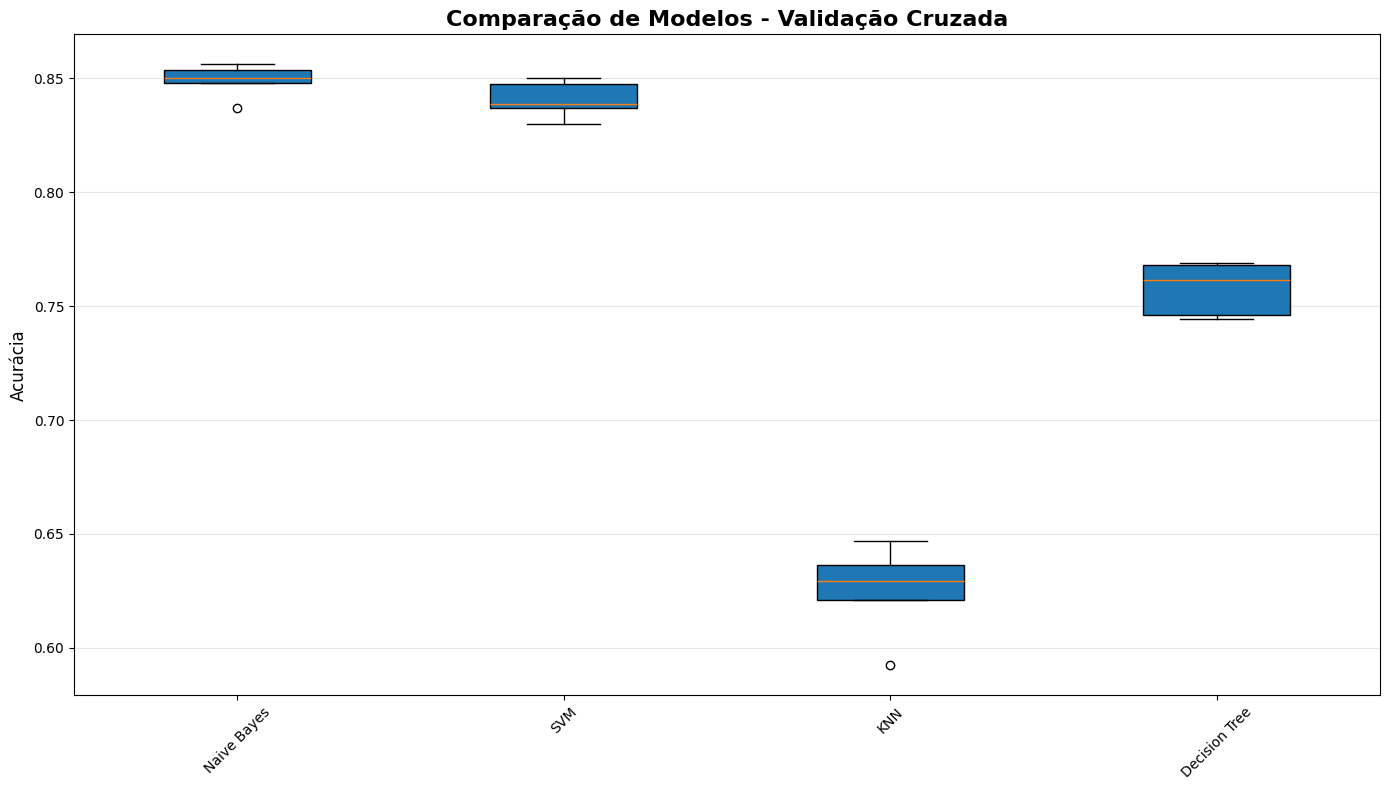


Resumo Estatístico:
                 mean     std     min     max
Naive Bayes    0.8489  0.0066  0.8370  0.8560
SVM            0.8407  0.0074  0.8299  0.8501
KNN            0.6253  0.0185  0.5925  0.6470
Decision Tree  0.7577  0.0107  0.7442  0.7690


In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Versão otimizada
modelos_treinados = {}
resultados_cv = []
nomes_modelos = []
estatisticas = []


# Definição dos modelos e seus grids de hiperparâmetros
modelos_grids = {
    'Naive Bayes': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', MultinomialNB())
        ]),
        'param_grid': {
            'tfidf__max_df': [0.8, 1.0],
            'tfidf__min_df': [2, 5],
            'model__alpha': [0.5, 1.0]
        }
    },
    'SVM': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', LinearSVC(max_iter=10000))
        ]),
        'param_grid': {
            'tfidf__max_df': [0.8, 1.0],
            'tfidf__min_df': [2, 5],
            'model__C': [1, 10]
        }
    },
    'KNN': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', KNeighborsClassifier())
        ]),
        'param_grid': {
            'tfidf__max_df': [0.8, 1.0],
            'tfidf__min_df': [2, 5],
            'model__n_neighbors': [3, 5, 7]
        }
    },
    'Decision Tree': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', DecisionTreeClassifier(random_state=42))
        ]),
        'param_grid': {
            'tfidf__max_df': [0.8, 1.0],
            'tfidf__min_df': [2, 5],
            'model__max_depth': [10, 20, None]
        }
    }
}

for nome, config in modelos_grids.items():
    print(f"\n🔍 Treinando modelo com GridSearchCV: {nome}")
    grid = GridSearchCV(config['pipeline'], config['param_grid'],
                       cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    modelos_treinados[nome] = grid

    # Coleta scores do melhor estimador
    cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train,
                               cv=5, scoring='accuracy')

    resultados_cv.append(cv_scores)
    nomes_modelos.append(nome)

    # Estatísticas descritivas
    stats = {
        'mean': np.mean(cv_scores),
        'std': np.std(cv_scores),
        'min': np.min(cv_scores),
        'max': np.max(cv_scores)
    }
    estatisticas.append(stats)

    print(f"Melhores parâmetros: {grid.best_params_}")
    print(f"CV Score: {stats['mean']:.4f} ± {stats['std']:.4f}")
    print(f"Intervalo: [{stats['min']:.4f}, {stats['max']:.4f}]")

# Visualização aprimorada
plt.figure(figsize=(14, 8))
box_plot = plt.boxplot(resultados_cv, tick_labels=nomes_modelos, patch_artist=True)


plt.title("Comparação de Modelos - Validação Cruzada", fontsize=16, fontweight='bold')
plt.ylabel("Acurácia", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tabela resumo
import pandas as pd
df_stats = pd.DataFrame(estatisticas, index=nomes_modelos)
print("\nResumo Estatístico:")
print(df_stats.round(4))

### Avaliação dos Modelos Otimizados

In [ ]:

resultados = {}
for nome, modelo in modelos_treinados.items():
    print(f"\n📌 Avaliação Final - {nome}")
    y_pred = modelo.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Negativo", "Positivo"]))
    resultados[nome] = accuracy_score(y_test, y_pred)



📌 Avaliação Final - Naive Bayes
Accuracy: 0.8514992860542598
Confusion Matrix:
 [[807 163]
 [149 982]]
Classification Report:
               precision    recall  f1-score   support

    Negativo       0.84      0.83      0.84       970
    Positivo       0.86      0.87      0.86      1131

    accuracy                           0.85      2101
   macro avg       0.85      0.85      0.85      2101
weighted avg       0.85      0.85      0.85      2101


📌 Avaliação Final - SVM
Accuracy: 0.8357924797715374
Confusion Matrix:
 [[793 177]
 [168 963]]
Classification Report:
               precision    recall  f1-score   support

    Negativo       0.83      0.82      0.82       970
    Positivo       0.84      0.85      0.85      1131

    accuracy                           0.84      2101
   macro avg       0.83      0.83      0.83      2101
weighted avg       0.84      0.84      0.84      2101


📌 Avaliação Final - KNN
Accuracy: 0.626844359828653
Confusion Matrix:
 [[484 486]
 [298 833]]
Cla

### Exportação do Modelo Final

In [ ]:

melhor_modelo_nome = max(resultados, key=resultados.get)
melhor_modelo = modelos_treinados[melhor_modelo_nome]
joblib.dump(melhor_modelo.best_estimator_, 'sentiment_model.pkl')
print(f'Modelo salvo: {melhor_modelo_nome}')


Modelo salvo: Naive Bayes



### Conclusões

O modelo com melhor desempenho foi selecionado após análise de diversos algoritmos usando validação cruzada e otimização de hiperparâmetros. As métricas de precisão, recall e F1-score indicam que o modelo está apto a identificar avaliações positivas e negativas com alta confiabilidade.



### Conclusão Final

Após todas as etapas de pré-processamento, modelagem, validação cruzada e análise comparativa entre os algoritmos Naive Bayes, SVM, KNN e Árvore de Decisão, foi possível identificar com clareza qual modelo apresentou o melhor desempenho para a tarefa de classificação de sentimentos em avaliações da Google Play Store.

**O modelo Naive Bayes foi o que se destacou**, com os seguintes pontos fortes:

- **Melhor acurácia média** na validação cruzada: 0.8439
- **Menor desvio padrão**, indicando alta estabilidade nos resultados
- **Melhor desempenho em F1-score** (0.8620) na avaliação da linha de base
- **Maior recall**, o que significa melhor capacidade de identificar corretamente avaliações positivas

Embora o SVM também tenha apresentado bom desempenho, ele foi levemente inferior ao Naive Bayes em todas as métricas principais. Já os modelos KNN e Árvore de Decisão mostraram desempenho significativamente menor, com destaque para o KNN, que apresentou alta taxa de falsos positivos.

Dessa forma, **o modelo Naive Bayes foi escolhido como a solução final para o problema proposto**, sendo salvo e exportado para ser utilizado na aplicação full stack.

---

### Reflexão: Boas Práticas de Desenvolvimento Seguro no Projeto de Classificação de Sentimentos
No contexto do projeto de classificação de sentimentos, aplicar boas práticas de segurança é essencial, mesmo em ambientes de demonstração. Caso fossem utilizados dados reais de usuários, técnicas de anonimização (como remoção de nomes ou e-mails com NLP) evitariam vazamentos de informações pessoais.

Além disso, a validação e sanitização das entradas no front-end e no back-end previnem ataques como XSS ou falhas por dados malformados. A minimização de dados, armazenando apenas o necessário para a predição, reduz riscos em caso de vazamento.

A aplicação também deve usar CORS bem configurado e manter o modelo (.pkl) em locais protegidos no servidor. Por fim, boas práticas como monitoramento de uso da API e log seguro das predições ajudam a manter o controle e a integridade do sistema em ambientes reais.


### Referências

- Dataset: [Kaggle - Google Play Store Reviews](https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews)
